In [1]:
import numpy as np
import statistics as sts
from matplotlib import pyplot as plt
from importlib import reload
import time
import math
import imp
import singlescale_online_quantile as sq
import singlescale_shift_online_quantile as ssq
import multiscale_online_quantile as mq
import multiscale_online_shift_quantile as msq
%matplotlib inline

# Sudden change detect 

We use the test function (piecewise constant function for sudden change) to transform the data space to coefficeient space. In coefficient space, the behavior of the sudden change is the outlier. By transforming the data space to coefficient space, we transform the sudden change detect to the outlier detect. 

# Outlier detect 

For the outlier detect, there are several standard methods. We introduce the Z-Score method (the mean and standard deviation) and the IQR (InterQuartile Range, use the quartile).

## Z-Score Method
Z-score is a parametric outlier detection method in a one or low dimensional feature space.
{\color{red} This technique assumes a Gaussian distribution of the data}. The outliers are the data points that are in the tails of the distribution and therefore far from the mean. How far depends on a set threshold $z_{t h r}$ for the normalized data points $z_{i}$ calculated with the formula:
$$
z_{i}=\frac{x_{i}-\mu}{\sigma},
$$
where where $x_{i}$ is a data point, $\mu$ is the mean of all $x_{j}$ and $\sigma$ is the standard deviation of all $x_{i}$.
An outlier is then a normalized data point which has an absolute value greater than $z_{\text {thr }}$. That is:
$$
\left|z_{i}\right|>z_{\text {thr }}
$$
Commonly used $z_{\text {thr }}$ values are $2.5,3.0$ and $3.5 .$

+ The advantage of the Z-score method : the mean and standard deviation can be calculated online. Thus, they can be calculated very efficiently. $\bar x_n$ denotes the sample mean of the first n samples (x1, ..., xn), $s_n^2$ denote the sample variance， then
$$
\bar x_n = \frac{(n-1)\bar x_{n-1} + x_n}{n} = \bar x_{n-1} + \frac{x_n - \bar x_{n-1}}{n}
$$
$$
s_n^2  = \frac{n-2}{n-1}s_{n-1}^2 + \frac{(x_n - \bar x_{n-1})^2}{n}, n\geq 2.
$$

+ The disadvantage of the Z-score method : the mean and standard deviation is sentitive to the outlier. Thus, the result of the detect is not very accurate and sometimes strange.

## IQR method 
Thiș is the simplest, nonparametric outlier detection method in a one dimensional feature space. Here outliers are calculated by means of the $I Q R$ (InterQuartile Range).

A quantile is the element at a certain rank in the dataset after sort. The first $25\%$ and the third $75\%$ quartile $(Q_1, Q_3)$ are calculated. An outlier is then a data point $x_{i}$ that lies outside the interquartile range. That is:
$$
\begin{array}{c}
x_{i}>Q_3+k(I Q R) \vee x_{i}<Q_1-k(I Q R) \\
\text { where } I Q R=Q 3-Q 1 \text { and } k \geq 0
\end{array}
$$
Using the interquartile multiplier value $k=1.5$, the range limits are the typical upper and lower whiskers of a box plot.

+ The advantage of IQR method is that : Compare with means and standard deviations, the quantile are less sensitive to outlier, so the result is more accurate.
+ The disadvantege of the IQR method:
    + the computation of the exact quantitle is expansive. It is difficult for the large data file or streaming data. However, there are several fast algorithms to calculate the approiximate quantile. I am reading this paper now and I think I need several days to finish it.
    + the IQR method is only useful for on dimension.

# create sudden change data

the length of the data is 100000, first change happens at 30000, second change happens at 70000. In this file, we use the IQR method to detect the outlier.

In [2]:
data = mq.sudden_drift_data(initial=0.8,final=0.4,
                        change1 = 30000,change2 = 70000,total_time=100000)

## Singlescale online detect

We summarize the singlescale online detect algorithm as the following:
+ $x_1, x_2, \cdots, x_t, \cdots$ is the stream data set we detect;  Given the scale parameter $m$; threshold parameter  $\sigma$; $f$ is the test function define on $[0, 1]$; $W$ denote an empty stream data set; $A$ denote an empty coefficient set. 
+ For $k = 1, 2, \cdots $
    + $W := W \cup \{ \text{add $2^m$ new elements}\}$; we use $s_0, s_1, \ldots, s_{2^m-1}$ to denete the new $2^m$ elements,
    + Calculate the coefficient for the new $2^m$ new elements:
    \begin{equation}\label{s-t}
    a = \sum_{i=0}^{2^m-1}f(t_i)s_i,
    \end{equation}
    where $t_i = (i+0.5)/2^m$.
    + Add the new coefficient to the coefficient set $A := A \cup \{a\}$.
    + Calcuate the $Q_1, Q_2$, where $25\%, 75\%$ quantile number for the coefficient set. Let $IQR = Q_3 - Q_1$.
    + If $a < Q_1 - \sigma IQR$ or $a > Q_3 + \sigma IQR$:
        + Conclude the change happens between the new $2^m$ elements 
        + Set the coefficient set $A = {}$ to be an empty set.
        
Computation for calculating the coefficients : If we assume the length of the stream data if $N$, then, for a fixed scale $m$, we need do $\frac{N}{2^m}$ times $2^m$ summation.

ANOMALY: scale: 1, partition: [30000,30002], amplitude: 0.1823245239645973, lower: -0.042433954640770544, upper: 0.04230377683438058
ANOMALY: scale: 1, partition: [70000,70002], amplitude: -0.1978847288082367, lower: -0.04279938990694715, upper: 0.04282038052478644

coeffTime : 0.5621685981750488

IQRTime : 18.069312572479248

addTime : 1.6530795097351074

appendTime : 2.0463733673095703

appendIQRTime : 2.1503238677978516

findchangeTime : 0.07546782493591309

time : 24.680094242095947
anomalyInteral : {'level 1': [[30000, 30002], [70000, 70002]]}


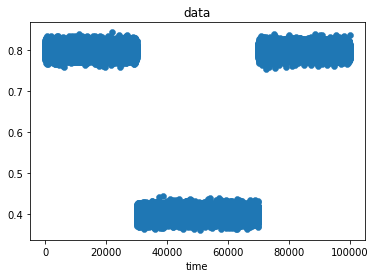

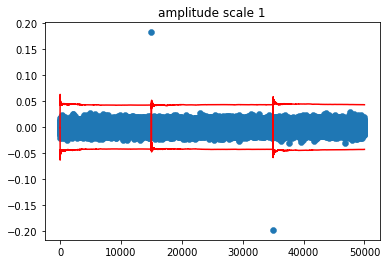

In [6]:
reload(sq)
test = sq.contstest
threshold = 4
scale = 1
start = time.time()
a, lower, upper, anomalyInteral  = sq.singlescale_online(data, test, threshold, scale)
end = time.time()
fig1, fig2 = sq.plot_amplitudes(data, a, lower, upper, scale)
print('time : {}'.format(end - start))
print('anomalyInteral : {}'.format(anomalyInteral))

**scale** | 1 | 2 |3 | 4 | 5 | 6 | 7 | 8 | 9 | 10|
--- | --- | ---|--- | --- | ---|--- | --- | ---|--- | --- | 
**cofficient time**  | 0.4666 |  0.2230 | 0.1097  | 0.0529  | 0.0259 | 0.0131 | 0.0088 | 0.0043 | 0.0027 | 0.0017 |
**IQR time**       | 15.8939 | 6.0263  | 2.5172  | 1.1220  | 0.5221 | 0.2508 | 0.1407 | 0.0627 | 0.0349 | 0.0195 |
**total time**     | 21.8146 | 8.4379 | 3.5943  | 1.6517  | 0.7810 | 0.3800 | 0.2210 | 0.1047 | 0.0583 | 0.0365 |

## singlescale shift online detect

We summarize the singlescale shift online detect algorithm as following:
+ $x_1, x_2, \cdots, x_t, \cdots$ is the data set we detect;  Given the scale parameter $m$; threshold parameter  $\sigma$; $f$ is the test function define on $[0, 1]$; $W$ denote an empty stream data set; $A$ denote an empty coefficient set.
+ $W := \cup \{\text{add $2^m$ new elements}\}$ 
+ For $k = 1, 2, \cdots $
    + $W := W \cup \{ \text{add $2^m$ new elements}\}$; we use $s_0, s_1, \ldots, s_{2^m-1}$ to denete the new $2^m$ elements, and the $s_{-2^m}, s_{-2^m+1}, \ldots, s_{-1}$ to denote the last $2^m$ elements in old $W$,
    + $C$ an empty set to store the coeffients for the new $2^m$ element,
    + for $j = 1, 2, \ldots, 2^m$
        + Calculate the coefficient for the element $s_{-2^m + j}, s_{-2^m + j+1}, \ldots, s_{j-1}$:
        $$
        a = \sum_{i=0}^{2^m-1}f(t_i)s_{-2^m + j + i},
        $$
        where $t_i = (i+0.5)/2^m$.
        + $C := C \cup \{a\}$
    + $idx = \text{the index the max number in the absolate of C}$
    + Add the new coefficient to the coefficient set $A := A \cup \{C[idx]\}$.
    + Calcuate the $Q_1, Q_2$, where $25\%, 75\%$ quantile number for the coefficient set. Let $IQR = Q_3 - Q1$.
    + If $C[idx] < Q_1 - \sigma IQR$ or $C[idx] > Q_3 + \sigma IQR$:
        + Conclude the change happens between $s_{-2^m + idx}, s_{-2^m + idx+1}, \ldots, s_{idx-1}$ 
        + Set the coefficient set $A = {}$ to be an empty set.

Computation for calculating coefficient : If we assume the length of the stream data if $N$, then, for a fixed scale $m$, we need do $N - 2^m + 1$ times $2^m$ summation.

ANOMALY: scale: 2, partition: [29999,30003], amplitude: 0.20329946179900707, lower: -0.06027973060086042, upper: 0.06031726952340303
ANOMALY: scale: 2, partition: [69999,70003], amplitude: -0.1988290187088446, lower: -0.05966781201385364, upper: 0.059804537105101765

coeffTime : 1.6977832317352295

IQRTime : 6.093077182769775

addTime : 0.8020226955413818

appendTime : 0.7342238426208496

appendIQRTime : 0.6694283485412598

findchangeTime : 0.03143906593322754

time : 10.152550220489502
anomalyInteral : {'level 2': [[29999, 30003], [69999, 70003]]}


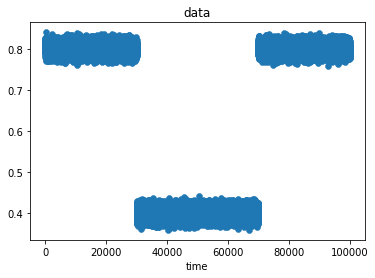

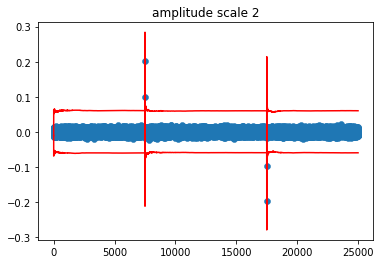

In [31]:
reload(ssq)
test = ssq.contstest
threshold = 4
scale = 2
start = time.time()
a, lower, upper, anomalyInteral  = ssq.singlescale_shift_online(data, test, threshold, scale)
end = time.time()
fig1, fig2 = ssq.plot_amplitudes(data, a, lower, upper, scale)
print('time : {}'.format(end - start))
print('anomalyInteral : {}'.format(anomalyInteral))

**scale** | 1 | 2 |3 | 4 | 5 | 6 | 7 | 8 | 9 | 10|
--- | --- | ---|--- | --- | ---|--- | --- | ---|--- | --- | 
**cofficient time**  | 2.0310 | 1.7261  |1.5069 | 1.3741    | 1.3479 | 1.3285 |  1.5479 | 1.8042 | 1.8243 |  2.1602 |
**IQR time**      | 15.9050  | 6.1988  | 2.5479 | 1.1418    | 0.5348 | 0.2548 |  0.1302 | 0.0710 | 0.0329 |0.0166 |
**total time**     | 23.5356 | 10.2852 | 5.1084 | 3.0205    | 2.1326  | 1.7079 | 1.7461 | 1.9115  | 1.8756 | 2.1867| 

Here the coefficient time is the total time for calculating the coefficient, the IQR time is the total time for calculating the $Q_1$ and $Q_3$.

#### singlescale online method
**scale** | 1 | 2 |3 | 4 | 5 | 6 | 7 | 8 | 9 | 10|
--- | --- | ---|--- | --- | ---|--- | --- | ---|--- | --- | 
**cofficient time**  | 0.4666 |  0.2230 | 0.1097  | 0.0529  | 0.0259 | 0.0131 | 0.0088 | 0.0043 | 0.0027 | 0.0017 |
**IQR time**       | 15.8939 | 6.0263  | 2.5172  | 1.1220  | 0.5221 | 0.2508 | 0.1407 | 0.0627 | 0.0349 | 0.0195 |
**total time**     | 21.8146 | 8.4379 | 3.5943  | 1.6517  | 0.7810 | 0.3800 | 0.2210 | 0.1047 | 0.0583 | 0.0365 |

#### singlescale shift online method
**scale** | 1 | 2 |3 | 4 | 5 | 6 | 7 | 8 | 9 | 10|
--- | --- | ---|--- | --- | ---|--- | --- | ---|--- | --- | 
**cofficient time**  | 2.0310 | 1.7261  |1.5069 | 1.3741    | 1.3479 | 1.3285 |  1.5479 | 1.8042 | 1.8243 |  2.1602 |
**IQR time**      | 15.9050  | 6.1988  | 2.5479 | 1.1418    | 0.5348 | 0.2548 |  0.1302 | 0.0710 | 0.0329 |0.0166 |
**total time**     | 23.5356 | 10.2852 | 5.1084 | 3.0205    | 2.1326  | 1.7079 | 1.7461 | 1.9115  | 1.8756 | 2.1867| 

+ From the table, we can observe the most time calculate is spend on calculate the IQR. Thus, using a fast algorithm to calculate the IQR for the streaming data is necessary. This is what I am doing now.
+ Compare the coefficient time for both method : singlescale shift online method is approximate $2^m$ times for the singlescale online method
+ For the singlescale online method, the IQR time spends the most times for all scales. However, for the singlescale shift online method, the coefficient time spends the most time in for the large scale. Thus, if we use fast algorithm for calculate IQR time, the singlescale online method will improve significantly; the singlescale shift online method for the large scale just imporve a little bit.
+ The phenomenon I am not clear is that : the coefficient time for singlescale shift online method is decrease from scale 1 to scale 6 and then increse. If we assume the length of the stream data if $N$, then, for a fixed scale $m$, we need do $N - 2^m + 1$ times $2^m$ summation. So if $m$ increase, I think the coefficient time will also increase. I do not how to explain this phenomenon at this moment.